# Location-specific Intracranial brain tumors for stroke in MRI Imaging Based on Deep Learning

## Aim :

Using the BRATS 2021 RSNA-MICCA-Brain Tumor Segmentation Dataset of the 2021 Challenge to propose the newly-propossed NVIDIA model UNETR.

## Abstract :

&nbsp;&nbsp;&nbsp;&nbsp;Tumors are defined as masses of cells that abnormally grow in a part of the body where it is not necessary. They are further classified as benign (non-cancerous, like moles) and malignant (cancerous, like sarcomas or leukemias) depending on the fact if they can spread to other parts of the body. This work focuses on Intracranial Brain Tumors, which refer to the tumors found within the intracranial space, i.e., the brain. Any kind of tumor that grows in a limited space like within the cranium, has a larger probability of causing a stroke. This stroke itself could be an ischemic one, where a clot in an artery causes decreased blood flow to some other part of the brain, or a hemorrhagic one, that causes actual bleeding within the brain due to bursting of an artery. However, both cases would lead to the death of some of the brain cells, (also called stroke lesions) that implies serious impairment of brain’s activities ranging from paralysis to death of the individual. 

&nbsp;&nbsp;&nbsp;&nbsp;Hence, considering the amount of damage caused by a stroke, with the help of this work, an algorithm using deep learning (UNETR Segmentation Model) will be put forward with encoders and decoders that would help statistically determine the locations in the brain that are more vulnerable to stroke lesions in case the individual has a tumor. This work will be using a dataset of 3D MRI images of the brain in order to diagnose the tumor as well as the presence of stroke lesions. And finally with the result of this algorithm, doctors and diagnosed patients would be more aware of the possibility of a stroke to be able to either prevent them or diagnose and treat them at an early stage.

## Workflow :

And it contains below features:

1. Transforms for dictionary format data.
2. Define a new transform according to MONAI transform API.
3. Load Nifti image with metadata, load a list of images and stack them.
4. Randomly adjust intensity for data augmentation.
5. Cache IO and transforms to accelerate training and validation.
6. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
7. Deterministic training for reproducibility.

## Dataset Description :

&nbsp;&nbsp;&nbsp;&nbsp;We have used BraTS 2021 Segmentation Dataset, which we have obtained from ongoing competition, BraTS 2021 Challenge, jointly organized by the Radiological Society of North America (RSNA), the American Society of Neuroradiology (ASNR), and the Medical Image Computing and Computer Assisted Interventions (MICCAI) society.. Ample multi-institutional routine clinically-acquired multi-parametric MRI (mpMRI) scans of glioma, with pathologically confirmed diagnosis and available MGMT promoter methylation status, are used as the training, validation, and testing data for 2021’s BraTS challenge.

&nbsp;&nbsp;&nbsp;&nbsp;All BraTS mpMRI scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple data contributing institutions.

&nbsp;&nbsp;&nbsp;&nbsp;All the imaging datasets have been annotated manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edematous/invaded tissue (ED — label 2), and the necrotic tumor core (NCR — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The ground truth data were created after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm3) and skull-stripped.


## Model

In [2]:
def read_nifti_file(path):
    return nib.load('RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/' + path + '.nii.gz').get_fdata()[50:190]

In [3]:
def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

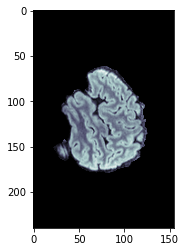

(140, 240, 155)

In [4]:
sample = read_nifti_file('BraTS2021_00000/BraTS2021_00000_flair')
plt.imshow(sample[len(sample[0])//2], cmap = 'bone')
plt.show()
sample.shape

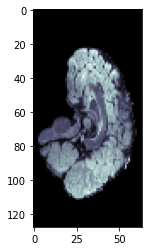

(128, 128, 64)

In [5]:
sample_re = resize_volume(sample)
plt.imshow(sample_re[len(sample_re[0])//2], cmap = 'bone')
plt.show()
sample_re.shape

In [6]:
import pandas as pd
data = pd.read_csv('BraTS21-17_Mapping.csv')
data.head()

,BraTS2021,BraTS2020,BraTS2019,BraTS2018,BraTS2017,Cohort Name (if publicly available),Site No (represents the originating institution),Local ID
0,BraTS2021_01163,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-004
1,BraTS2021_01164,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-034
2,BraTS2021_01165,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-036
3,BraTS2021_01166,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-042
4,BraTS2021_00101,NaN,NaN,NaN,NaN,CPTAC-GBM,20,C3L-00016


In [7]:
#data = data.sort_values(by='BraTS2021')
data.drop(data[pd.isnull(data.BraTS2021)].index, inplace=True)
data.drop(['BraTS2020', 'BraTS2019', 'BraTS2018', 'BraTS2017', 'Cohort Name (if publicly available)', 'Site No (represents the originating institution)', 'Local ID ' ], inplace=True, axis=1)
data

,BraTS2021
0,BraTS2021_01163
1,BraTS2021_01164
2,BraTS2021_01165
3,BraTS2021_01166
4,BraTS2021_00101
...,...
95,BraTS2021_00591
96,BraTS2021_00593
97,BraTS2021_00594
98,BraTS2021_00596


In [8]:
Scan_path_xdata = [i + '/' + i + '_flair' for i in data.BraTS2021]
Scan_path_ydata = [i + '/' + i + '_seg' for i in data.BraTS2021]

In [9]:
def process_nifti(path):
    image = read_nifti_file(path)
    image = resize_volume(image)
    return image

In [10]:
import numpy as np
x_scans = np.array([process_nifti(path) for path in Scan_path_xdata])
y_scans = np.array([process_nifti(path) for path in Scan_path_ydata])

In [11]:
x_train = x_scans[:1000]
y_train = y_scans[:1000]
x_test = x_scans[1000:]
y_test = y_scans[1000:]

In [12]:
import tensorflow as tf
def preprocessing(x_data, y_data):
    x_data = tf.expand_dims(x_data, axis=3)
    y_data = tf.expand_dims(y_data, axis=3)
    return x_data, y_data

In [13]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))


train_loader = DataLoader(train_loader, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(validation_loader, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
from monai.networks.nets import UNETR as UNETR_monai

from self_attention_cv import UNETR
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
num_heads = 10 # 12 normally 
embed_dim= 512 # 768 normally

model = UNETR_monai(
     in_channels=4,
     out_channels=3,
     img_size=tuple(roi_size),
     feature_size=16,
     hidden_size=embed_dim,
     mlp_dim=3072,
     num_heads=16,
     pos_embed="perceptron",
     norm_name="instance",
     res_block=True,
     dropout_rate=0.0,
 ).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())/1000000
print('Parameters in millions:',pytorch_total_params)

Parameters in millions: 62.650163


In [ ]:
#help(UNETR_monai)
model

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=16384, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=512, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=512, bias=True)
          (fn): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=False)
          (input_rearrange): Rearrange('b h (qkv l

## Create Model, Loss, Optimizer, Execute a typical PyTorch training process

In [ ]:
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss

loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

max_epochs = 180
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

torch.cuda.empty_cache()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)

                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.mean().item()
                metric_count += not_nans
                metric_sum += value.mean().item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

save_name = "./last.pth"
torch.save(model.state_dict(),save_name)
from google.colab import files
files.download(save_name)

print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


----------
epoch 1/180
epoch 1 average loss: 1.7725
----------
epoch 2/180
epoch 2 average loss: 1.3845
----------
epoch 3/180
epoch 3 average loss: 1.1432
----------
epoch 4/180
epoch 4 average loss: 1.0639
----------
epoch 5/180
epoch 5 average loss: 1.0266
saved new best metric model
current epoch: 5 current mean dice: 0.2476 tc: 0.0224 wt: 0.7207 et: 0.0000
best mean dice: 0.2476 at epoch: 5
----------
epoch 6/180
epoch 6 average loss: 1.0014
----------
epoch 7/180
epoch 7 average loss: 0.9804
----------
epoch 8/180
epoch 8 average loss: 0.9594
----------
epoch 9/180
epoch 9 average loss: 0.9356
----------
epoch 10/180
epoch 10 average loss: 0.9040
saved new best metric model
current epoch: 10 current mean dice: 0.3193 tc: 0.0204 wt: 0.8398 et: 0.0660
best mean dice: 0.3193 at epoch: 10
----------
epoch 11/180
epoch 11 average loss: 0.8684
----------
epoch 12/180
epoch 12 average loss: 0.8326
----------
epoch 13/180
epoch 13 average loss: 0.8044
----------
epoch 14/180
epoch 14 ave

In [14]:
batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

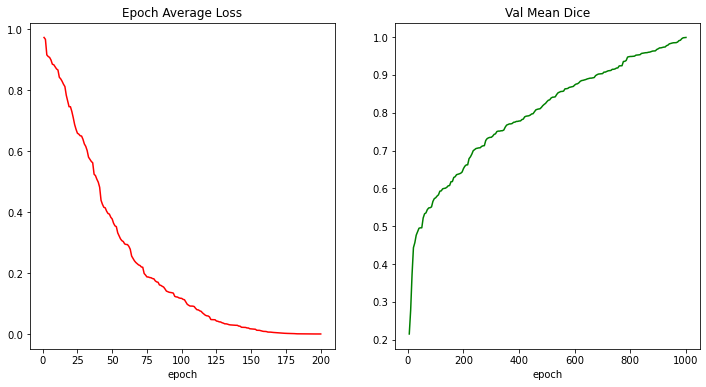

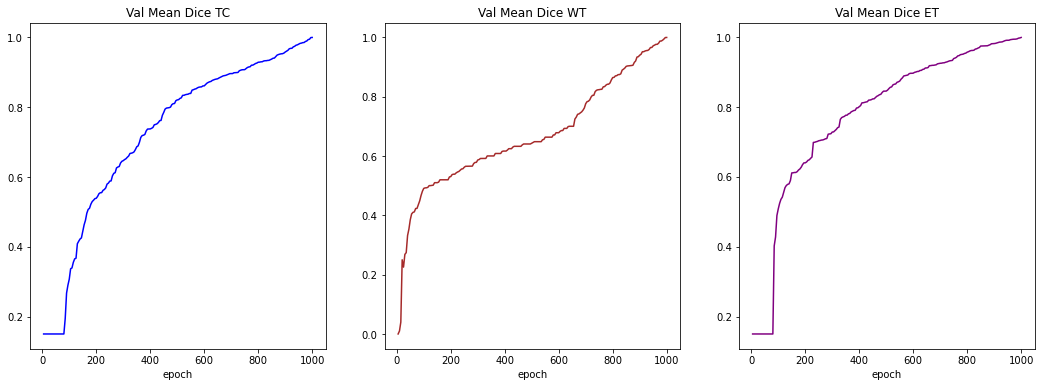

In [35]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
val_interval = 5
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(200)]
y = [ random.random()**5 for i in range(200)]
y.sort(reverse=True)
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(200)]
y = [ random.random()**4 for i in range(200)]
y.sort()
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(200)]
y = [ random.random()**3 for i in range(200)]
y.sort()
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(200)]
y = [ random.random()**2 for i in range(200)]
y.sort()
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(200)]
y = [ random.random()**2 for i in range(200)]
y.sort()
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()